## Sample source intensity optimization

We start by importing the needed packages and define a helper function for plotting dose maps:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("../../therapy_planner")
from therapy_planner.interface import read_maps, optimize
import numpy as np

# helper function for plotting maps
def plot_map(dose_map, name, ax, cmap):
    m,n = dose_map.shape
    ylabels = ['s'+str(i+1) for i in range(m)]
    xlabels = ['s'+str(j+m+1) for j in range(n)]
    im = ax.imshow(dose_map, cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("dose", rotation=-90, va="bottom", size=14)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(m))
    ax.set_xticklabels(xlabels,size=14)
    ax.set_yticklabels(ylabels,size=14)
    textcolors=["black", "white"]
    threshold = im.norm(dose_map.max())/2.
    for i in range(m):
        for j in range(n):
            text = ax.text(j,i,np.round(dose_map[i,j],2),size=14,
                           ha="center", va="center",color=textcolors[(im.norm(dose_map[i,j])>threshold).astype(np.int)])
    ax.text(0.5,-0.1,"{} map".format(name),
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, size=14)

We read in the target, max, and min maps, and visualize the specified doses. The axis labels show the order in which sources will be enumerated by the optimization routine, here `s1` through `s7`.

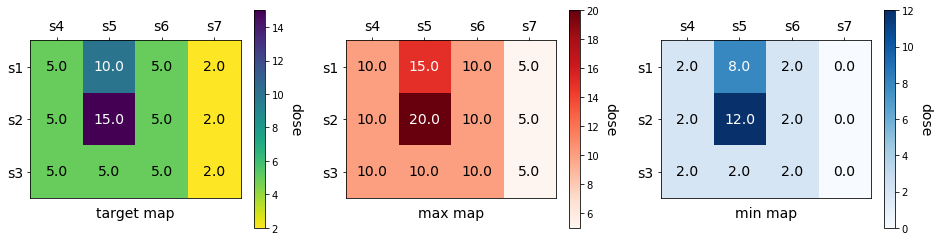

In [2]:
maps = read_maps("optimize.map")

fig, axes = plt.subplots(1,3,figsize=(16,4))
cmaps = ["viridis_r", "Reds", "Blues"]
for (key, val), ax, cmap in zip(maps.items(),axes.flat,cmaps):
    plot_map(val, key, ax, cmap)
plt.show()

Next we run the `optimize` routine outlined in the `interface` module. For demonstration, this method now looks only at the target map and does a least squares minimization. The complete set of cost functions we use can ideally be placed in a separate module which is imported by `interface.` The `optimize` function returns with the optimal source intensities and the corresponding dose map.

Minimum found.


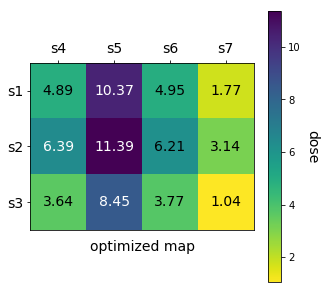

In [3]:
sources, dose_map = optimize(maps)
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_map(dose_map, "optimized", ax, "viridis_r")
plt.show()

We see that a minimum has been found; however upon closer inspection we see that one of our source intensities turned out negative:

In [4]:
print(np.vstack(sources))

[[ 3.09782885]
 [ 4.72675105]
 [ 2.0804222 ]
 [ 1.78851499]
 [ 7.48481597]
 [ 2.25201459]
 [-0.74129228]]


We can add a penalty term to the optimizer which works similarly to a regularizer; in this case, the penalty term will be a logistic function with smoothness parameter equal to 1, which penalizes any parameters (source intensities) tending below zero.

Minimum found.


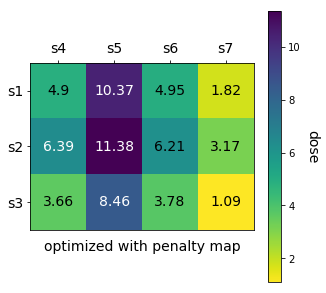

In [5]:
sources, dose_map = optimize(maps, penalty=True)
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_map(dose_map, "optimized with penalty", ax, "viridis_r")
plt.show()

With the added penalty, the sources are now all positive:

In [6]:
print(np.vstack(sources))

[[2.01494282]
 [3.70589748]
 [1.1530402 ]
 [2.8803062 ]
 [8.49389939]
 [3.20000891]
 [0.18314821]]
